# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# set values if testing
import os
from copy import deepcopy

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

import matplotlib.pyplot as plt

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20
BUDGET = 0.02 if SMOKE_TEST else 10

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'observables': []}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
my_vocs = deepcopy(tnk_vocs)
my_vocs.constraints = {}
generator = MultiFidelityGenerator(vocs=my_vocs, reference_point={"y1": 1.5, "y2": 1.5})

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
generator.cost_function = lambda s: s**3.5
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = N_MC_SAMPLES

X = Xopt(generator=generator, evaluator=evaluator, vocs=my_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.75, 1.0], "s": [0.0, 0.1]}))

X


            Xopt
________________________________
Version: 2.4.6.dev5+ga295b108.d20250107
Data size: 2
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  custom_objective: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_cached_hyperparameters: false
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  memory_length: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: multi_fidelity
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  reference_point:
    s: 0.0
    y1: 1.5
    y2: 1.5
  supp

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = BUDGET
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(
        f"n_samples: {len(X.data)} "
        f"budget used: {X.generator.calculate_total_cost():.4} "
        f"hypervolume: {X.generator.calculate_hypervolume():.4}"
    )

n_samples: 3 budget used: 0.002106 hypervolume: 0.07631


n_samples: 4 budget used: 0.002106 hypervolume: 0.07631


n_samples: 5 budget used: 0.004181 hypervolume: 0.07631


n_samples: 6 budget used: 0.004181 hypervolume: 0.07631


n_samples: 7 budget used: 0.008149 hypervolume: 0.3289


n_samples: 8 budget used: 0.0208 hypervolume: 0.3289


n_samples: 9 budget used: 0.02088 hypervolume: 0.3289


n_samples: 10 budget used: 0.04979 hypervolume: 0.3289


n_samples: 11 budget used: 0.1313 hypervolume: 1.099


n_samples: 12 budget used: 0.1946 hypervolume: 1.099


n_samples: 13 budget used: 0.7685 hypervolume: 1.099


n_samples: 14 budget used: 0.8031 hypervolume: 1.099


n_samples: 15 budget used: 0.8371 hypervolume: 1.099


n_samples: 16 budget used: 0.8454 hypervolume: 1.099


n_samples: 17 budget used: 0.8459 hypervolume: 1.099


n_samples: 18 budget used: 1.738 hypervolume: 1.099


n_samples: 19 budget used: 1.867 hypervolume: 1.099


n_samples: 20 budget used: 1.88 hypervolume: 1.099


n_samples: 21 budget used: 1.881 hypervolume: 1.099


n_samples: 22 budget used: 1.99 hypervolume: 1.099


n_samples: 23 budget used: 2.096 hypervolume: 1.099


n_samples: 24 budget used: 2.096 hypervolume: 1.099


n_samples: 25 budget used: 2.097 hypervolume: 1.099


n_samples: 26 budget used: 2.158 hypervolume: 1.099


n_samples: 27 budget used: 2.633 hypervolume: 1.099


n_samples: 28 budget used: 2.682 hypervolume: 1.099


n_samples: 29 budget used: 2.711 hypervolume: 1.099


n_samples: 30 budget used: 2.717 hypervolume: 1.099


n_samples: 31 budget used: 2.718 hypervolume: 1.099


n_samples: 32 budget used: 2.719 hypervolume: 1.099


n_samples: 33 budget used: 2.719 hypervolume: 1.099


n_samples: 34 budget used: 2.72 hypervolume: 1.099


n_samples: 35 budget used: 2.729 hypervolume: 1.099


n_samples: 36 budget used: 2.768 hypervolume: 1.099


n_samples: 37 budget used: 2.775 hypervolume: 1.099


n_samples: 38 budget used: 2.828 hypervolume: 1.099


n_samples: 39 budget used: 3.469 hypervolume: 1.982


n_samples: 40 budget used: 3.47 hypervolume: 1.982


n_samples: 41 budget used: 4.022 hypervolume: 1.982


n_samples: 42 budget used: 4.032 hypervolume: 1.982


n_samples: 43 budget used: 4.069 hypervolume: 1.982


n_samples: 44 budget used: 4.085 hypervolume: 1.982


n_samples: 45 budget used: 4.095 hypervolume: 1.982


n_samples: 46 budget used: 4.096 hypervolume: 1.982


n_samples: 47 budget used: 4.116 hypervolume: 1.982


n_samples: 48 budget used: 4.223 hypervolume: 1.982


n_samples: 49 budget used: 4.228 hypervolume: 1.982


n_samples: 50 budget used: 4.228 hypervolume: 1.982


n_samples: 51 budget used: 4.635 hypervolume: 1.982


n_samples: 52 budget used: 4.934 hypervolume: 1.982


n_samples: 53 budget used: 4.937 hypervolume: 1.982


n_samples: 54 budget used: 5.394 hypervolume: 1.982


n_samples: 55 budget used: 5.471 hypervolume: 1.982


n_samples: 56 budget used: 5.497 hypervolume: 1.982


n_samples: 57 budget used: 5.522 hypervolume: 1.982


n_samples: 58 budget used: 6.213 hypervolume: 1.982


n_samples: 59 budget used: 6.393 hypervolume: 1.982


n_samples: 60 budget used: 6.394 hypervolume: 1.982


n_samples: 61 budget used: 6.396 hypervolume: 1.982


n_samples: 62 budget used: 6.42 hypervolume: 1.982


n_samples: 63 budget used: 6.517 hypervolume: 1.982


n_samples: 64 budget used: 6.822 hypervolume: 1.982


n_samples: 65 budget used: 6.831 hypervolume: 1.982


n_samples: 66 budget used: 6.934 hypervolume: 1.982


n_samples: 67 budget used: 7.487 hypervolume: 1.982


n_samples: 68 budget used: 7.49 hypervolume: 1.982


n_samples: 69 budget used: 7.576 hypervolume: 1.982


n_samples: 70 budget used: 7.576 hypervolume: 1.982


n_samples: 71 budget used: 8.261 hypervolume: 1.982


n_samples: 72 budget used: 8.271 hypervolume: 1.982


n_samples: 73 budget used: 8.36 hypervolume: 1.982


n_samples: 74 budget used: 8.472 hypervolume: 1.982


n_samples: 75 budget used: 8.48 hypervolume: 1.982


n_samples: 76 budget used: 9.352 hypervolume: 1.982


n_samples: 77 budget used: 9.353 hypervolume: 1.982


n_samples: 78 budget used: 9.471 hypervolume: 1.982


n_samples: 79 budget used: 9.471 hypervolume: 1.982


n_samples: 80 budget used: 9.471 hypervolume: 1.982


n_samples: 81 budget used: 10.07 hypervolume: 1.982


## Show results

In [4]:
X.data

x1        x2         s               a        y1        y2  \
0   1.000000  0.750000  0.000000  dummy_constant  1.000000  0.750000   
1   0.750000  1.000000  0.100000  dummy_constant  0.750000  1.000000   
2   0.357861  1.154722  0.164093  dummy_constant  0.357861  1.154722   
3   0.040214  2.547410  0.000000  dummy_constant  0.040214  2.547410   
4   3.141590  0.000000  0.171167  dummy_constant  3.141590  0.000000   
..       ...       ...       ...             ...       ...       ...   
76  2.694509  1.254500  0.113334  dummy_constant  2.694509  1.254500   
77  0.637249  2.692220  0.542961  dummy_constant  0.637249  2.692220   
78  0.157453  0.505437  0.017528  dummy_constant  0.157453  0.505437   
79  0.183794  2.802547  0.044885  dummy_constant  0.183794  2.802547   
80  3.115031  2.175607  0.863826  dummy_constant  3.115031  2.175607   

           c1        c2  xopt_runtime  xopt_error  
0    0.626888  0.312500      0.000162       False  
1    0.626888  0.312500      0.000134       False  
2    0.451861  0.448864      0.000154       False  
3    5.394090  4.403292      0.000155       False  
4    8.769588  7.227998      0.000149       False  
..        ...       ...           ...         ...  
76   7.756929  5.385139      0.000149       False  
77   6.737934  4.824665      0.000151       False  
78  -0.731658  0.117368      0.000150       False  
79   6.838100  5.401707      0.000155       False  
80  13.531293  9.646047      0.000152       False  

[81 rows x 10 columns]

## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


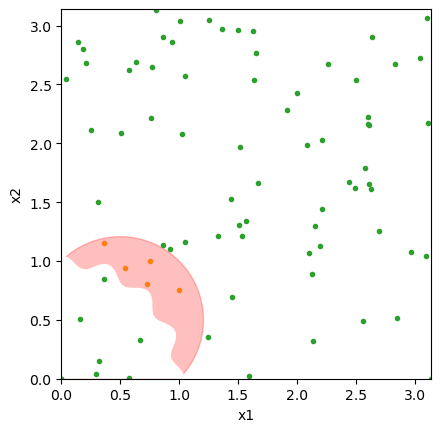

In [5]:
fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5**0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

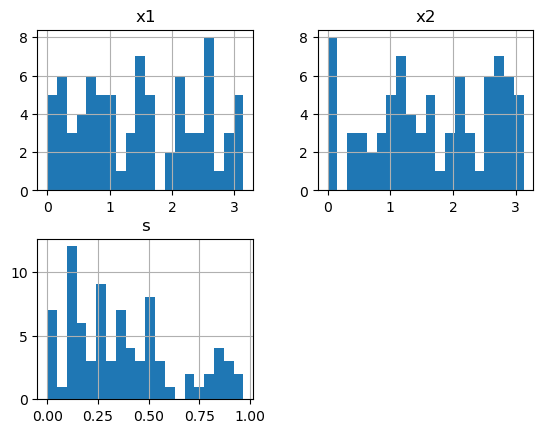

In [6]:
ax = history.hist(["x1", "x2", "s"], bins=20)

<Axes: >

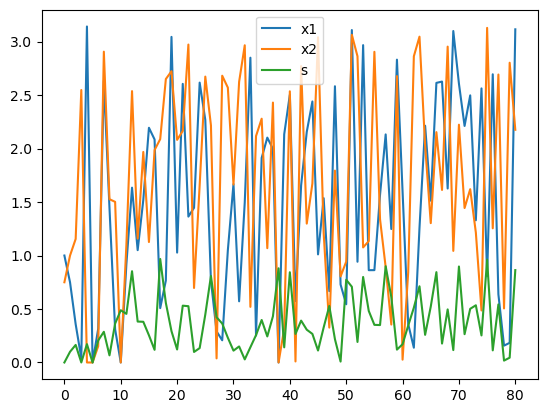

In [7]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[1.82690928 1.83293359]]


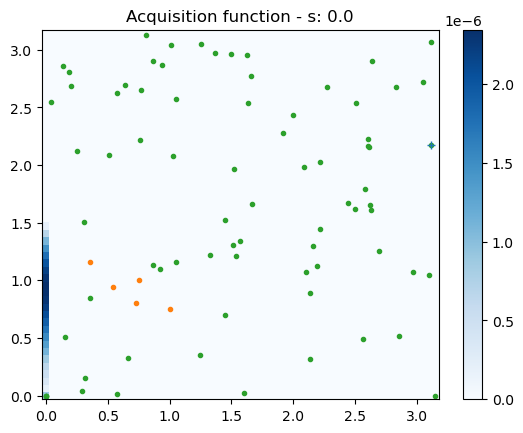

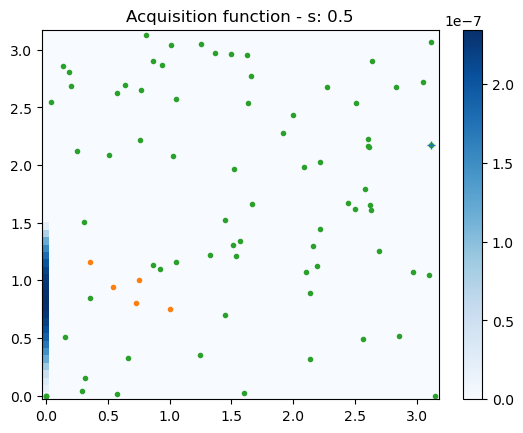

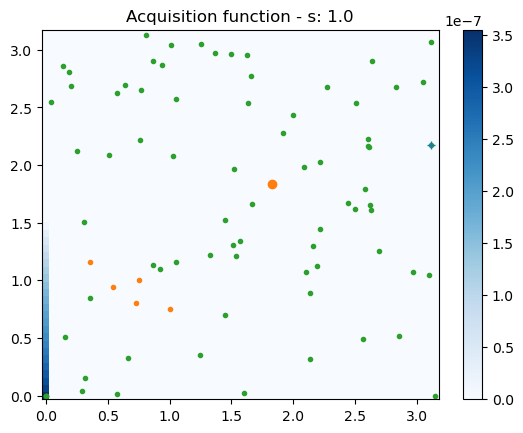

In [8]:
# plot the acquisition function

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh over non-fidelity parameters
n = 50
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0], 1) * fidelity, pts), dim=-1)

    acq_func = X.generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()

        xxn, yyn = xx.numpy(), yy.numpy()

        c = ax.pcolor(xxn, yyn, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = pd.DataFrame(X.generator.generate(1), index=[0])
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-105.5613], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0.3921, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_lengthscale',
  Parameter containing:
  tensor([[ 0.6990, 53.0394, 61.1428]], dtype=torch.float64, requires_grad=True))]